ARIMA 모델을 만들기 위해 p, d, q 값을 지정해 주어야 하는데 일반적으로 p가 0이면 MA 모델을 따르고, q가 0이면 AR 모델을 따른다고 한다.
d가 0이면 정상성을 보유한 모델이라고 보는데, 발생확률이 변하지 않는 ARMA 모델이라고 간주하면 된다 
우린 아직 이 데이터가 어떤 모형을 따르는 지 모르기 때문에 최적의 결과를 가져오는 p,d,q 값을 찾아야함 
임의의 값들을 다 넣어 테스트 해보거나, pmdarima 패키지의 auto_arima 함수로 찾아냄

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

df = pd.read_csv('./전복_전처리2.csv')

df.rename(columns = {'1kg 평균가격' : 'kg','월':'month','년도':'year','생산량':'pr','수온 (℃)':'tem (℃)','일시':'date'}, inplace = True)

In [82]:
df

,date,kg,month,year,pr,tem (℃)
0,2006-04-01,31600.000000,4.0,2006.0,1820.0,10.6
1,2006-04-03,34800.000000,4.0,2006.0,778.0,10.7
2,2006-04-04,33500.000000,4.0,2006.0,1210.0,11.1
3,2006-04-05,32100.000000,4.0,2006.0,930.0,11.4
4,2006-04-06,32800.000000,4.0,2006.0,768.0,11.9
...,...,...,...,...,...,...
4448,2021-04-03,21979.166667,4.0,2021.0,2310.0,12.6
4449,2021-04-05,18643.333333,4.0,2021.0,1718.0,12.6
4450,2021-04-06,19580.000000,4.0,2021.0,2717.0,12.9
4451,2021-04-07,19744.000000,4.0,2021.0,2073.0,13.6


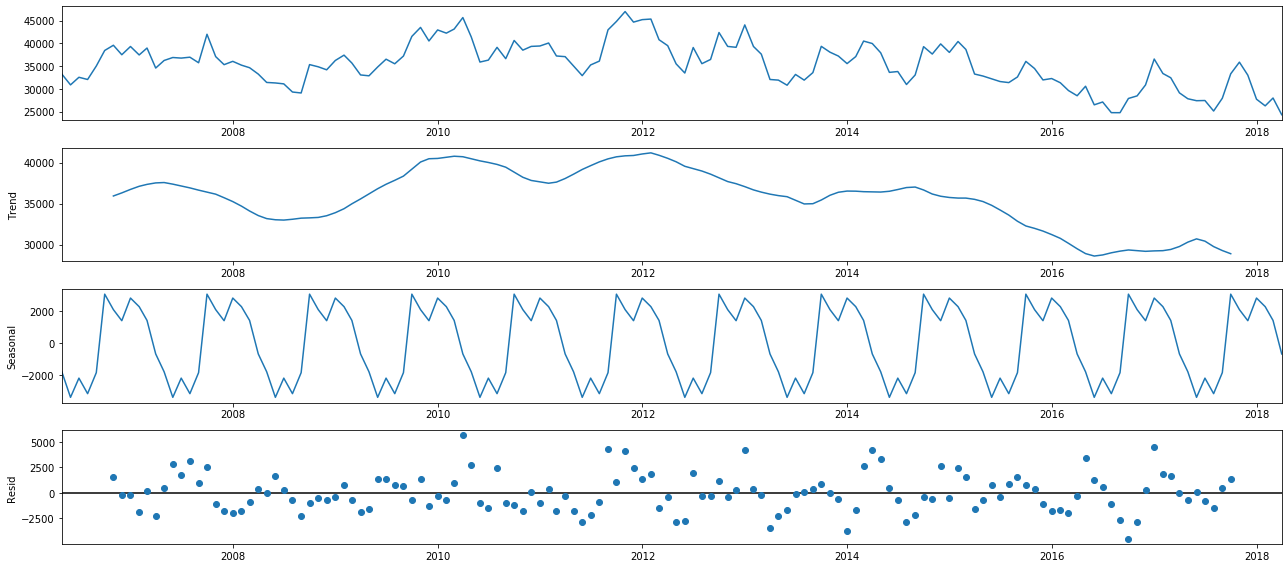

In [83]:
from pylab import rcParams
import statsmodels.api as sm
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

# string 형태의 date 필드를 datetime 형태로 변환
df['date'] =  pd.to_datetime(df['date'])

# date 필드를 index로 설정
df = df.set_index('date')

# 빠르게 테스트 해 보기 위해 월별로 kg 예측
# month = df.kg.resample('M').sum()
month = pd.DataFrame(df.kg.resample('M').mean(), columns=['kg'])

# #2013-2016 데이터를 train으로 2017 데이터를 test로 분리
# split = "2017-01-01"
# month_train= month[:split]
# month_test= month[split:]
# month_test_final=month_test.copy()

ratio = 0.8
cut = np.int(len(month)*ratio)
month_train = month[:cut]
month_test = month[cut:]
month_test_final=month_test.copy()



# 데이터를 시즌별로 분해해서 살펴 봄
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(month_train, model='additive')
fig = decomposition.plot()
plt.show()

In [84]:
# pip install pmdarima

In [85]:
# 최적의 조합 찾기
#방법 1. p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2) # pdq에 0,1 넣어줌

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(month_train, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
#방법 2. auto_arima 함수로 자동 추출
from pmdarima import auto_arima
stepwise_model = auto_arima(month_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3406.07103744664
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3030.5805597764065
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2595.603483745015
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2344.1320467937535
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2612.161696666795
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2592.046427166467
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2354.0375404618294
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2335.1284873656714
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3281.387792799832
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2983.4669991072606
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2512.5906992142
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2266.4643662894828
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3017.510337573007
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2973.7223099257467
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2293.470952516348
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2263.070469363525
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2650.9672314264863
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2425.560058998271
ARIMA

In [86]:
# AIC가 가장 작은 조합을 선택 Best model:  ARIMA(0,1,0)(0,1,2)[12]          

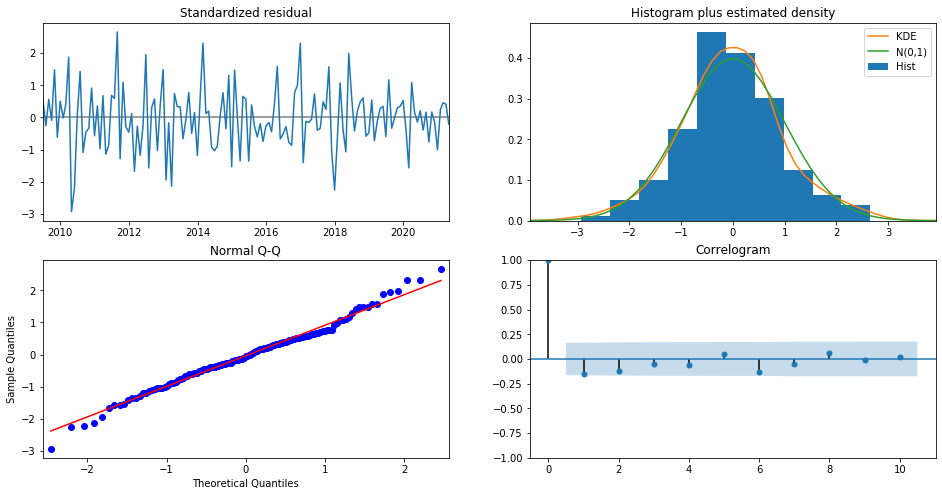

In [87]:
SARIMAMonth = sm.tsa.statespace.SARIMAX(month, order=(0, 1, 0), seasonal_order=(0, 1, 2, 12) ,enforce_stationarity=False,enforce_invertibility=False)

SARIMA_results_month = SARIMAMonth.fit()

SARIMA_results_month.plot_diagnostics(figsize=(16, 8))
plt.show()

1286.6376615203517


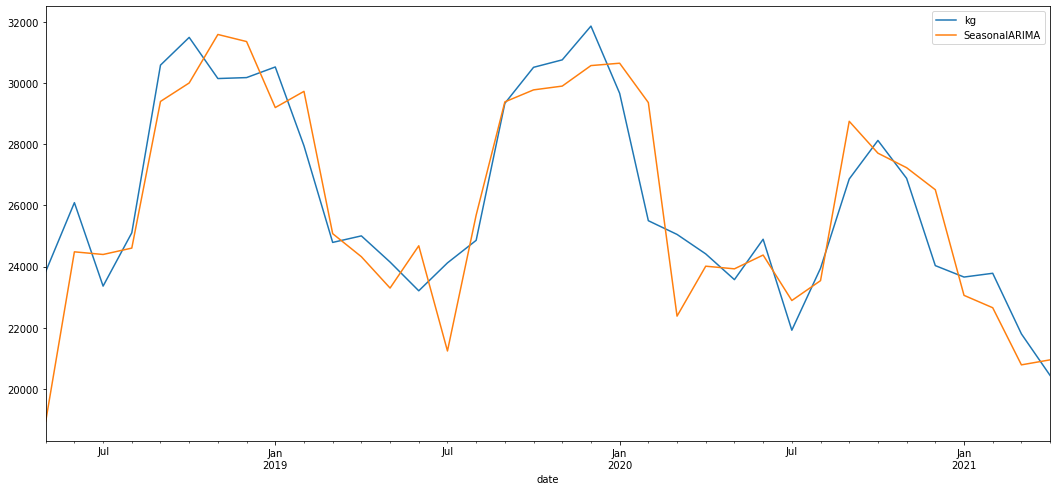

In [96]:
SARIMA_predict_month_1 = SARIMA_results_month.predict(start=cut,end=len(month))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
month_test_final['SeasonalARIMA'] = SARIMA_predict_month_1

# RMSE를 살펴 봄
RMSE_Month_Seasonal_ARIMA  = np.sqrt(np.mean((month_test_final['SeasonalARIMA'] - month_test_final['kg']) ** 2)) 
print(RMSE_Month_Seasonal_ARIMA)

# test 데이터와 예측 결과치를 비교
month_test_final[1:].plot()

In [89]:
## 앞으로의 월별 예측치

fore = SARIMA_results_month.forecast(steps=10)
print(fore)

2021-05-31    20121.258681
2021-06-30    20616.391431
2021-07-31    19221.238770
2021-08-31    20677.785578
2021-09-30    25338.969257
2021-10-31    26389.146546
2021-11-30    25673.905484
2021-12-31    25426.742194
2022-01-31    24264.424718
2022-02-28    22429.611415
Freq: M, dtype: float64


## 주별 예측

In [57]:
from pylab import rcParams
import statsmodels.api as sm
import statsmodels.tsa.seasonal as seasonal_decompose
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

df = pd.read_csv('./전복_전처리2.csv')

df.rename(columns = {'1kg 평균가격' : 'kg','월':'month','년도':'year','생산량':'pr','수온 (℃)':'tem (℃)','일시':'date'}, inplace = True)

df['date'] =  pd.to_datetime(df['date'])
df_2 = df.set_index('date')

week = pd.DataFrame(df_2.kg.resample('W').mean(), columns=['kg'])

### 결측치 제거

- 주별로 했을때 (도메인 지식)

In [58]:
week

,kg
date,
2006-04-02,31600.000000
2006-04-09,32966.666667
2006-04-16,34033.333333
2006-04-23,31561.904762
2006-04-30,34706.434837
...,...
2021-03-14,21261.467532
2021-03-21,22559.491588
2021-03-28,21481.954269


In [59]:
week.isnull().sum()

kg    14
dtype: int64

In [60]:
week.isnull()

,kg
date,
2006-04-02,False
2006-04-09,False
2006-04-16,False
2006-04-23,False
2006-04-30,False
...,...
2021-03-14,False
2021-03-21,False
2021-03-28,False


In [61]:
# 앞에 데이터로 넣어줌
week = week.fillna(method='ffill')

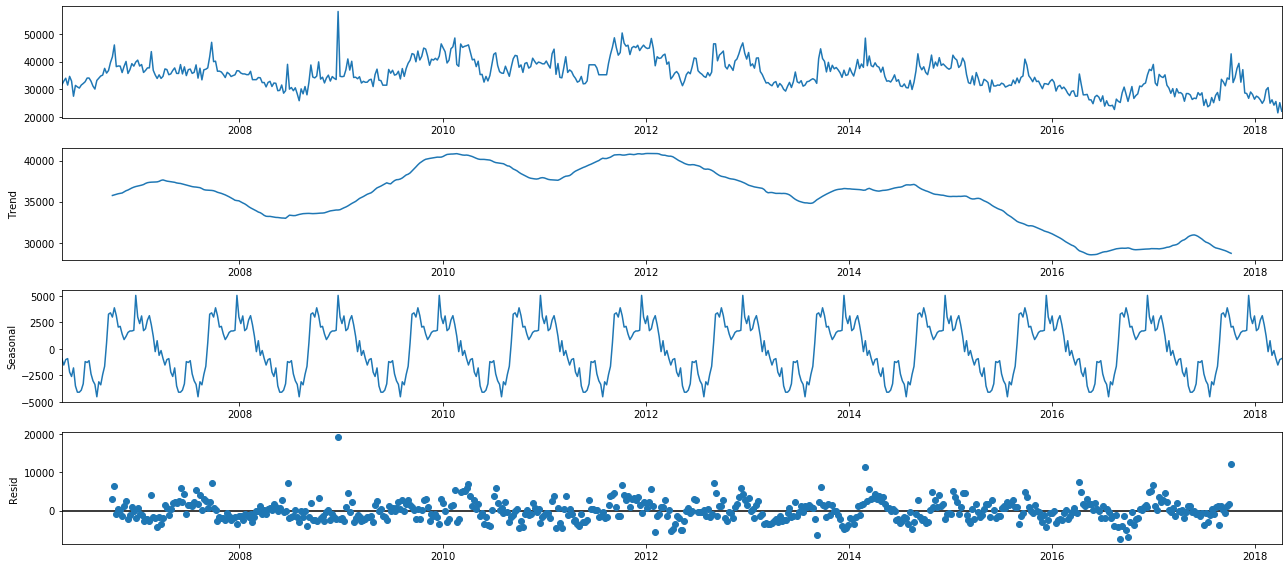

In [62]:
ratio = 0.8
cut = np.int(len(week)*ratio)
week_train = week[:cut]
week_test = week[cut:]
week_test_final=week_test.copy()

# 데이터를 시즌별로 분해해서 살펴 봄
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(week_train, model='additive')
fig = decomposition.plot()
plt.show()

In [33]:
# pip install pmdarima

In [34]:
#방법 1. p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2) # pdq에 0,1 넣어줌

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(week_train, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
#방법 2. auto_arima 함수로 자동 추출
from pmdarima import auto_arima
stepwise_model = auto_arima(week_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13378.667263713902
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:12720.499151865279
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:10937.186716714503
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10664.898687164023
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10955.512673469259
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10931.027246109576
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10701.140382163663
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10660.007188989464
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:12956.472178753265
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12587.765426684404
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:10739.038966824257
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10438.70958495071
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:10771.002743821846
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12533.049824679367
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:10499.494226272807
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10440.57454015106
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:10560.976517687057
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:10340.9977591

In [35]:
# AIC가 가장 작은 조합을 선택 Best model:  Best model:  ARIMA(0,1,2)(2,1,0)[12]   

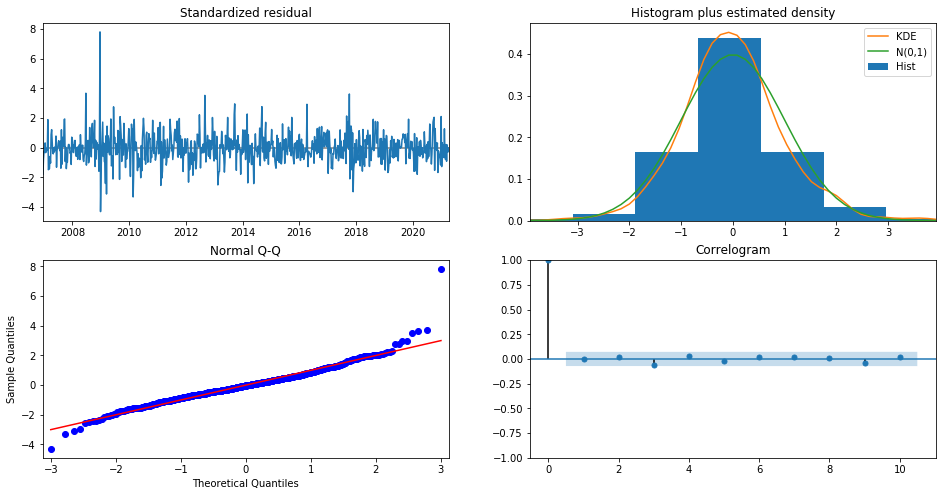

In [97]:
SARIMAweek = sm.tsa.statespace.SARIMAX(week, order=(0, 1, 2), seasonal_order=(2, 1, 0, 12) ,enforce_stationarity=False,enforce_invertibility=False)

SARIMA_results_week = SARIMAweek.fit()

SARIMA_results_week.plot_diagnostics(figsize=(16, 8))
plt.show()

2566.5963248744692


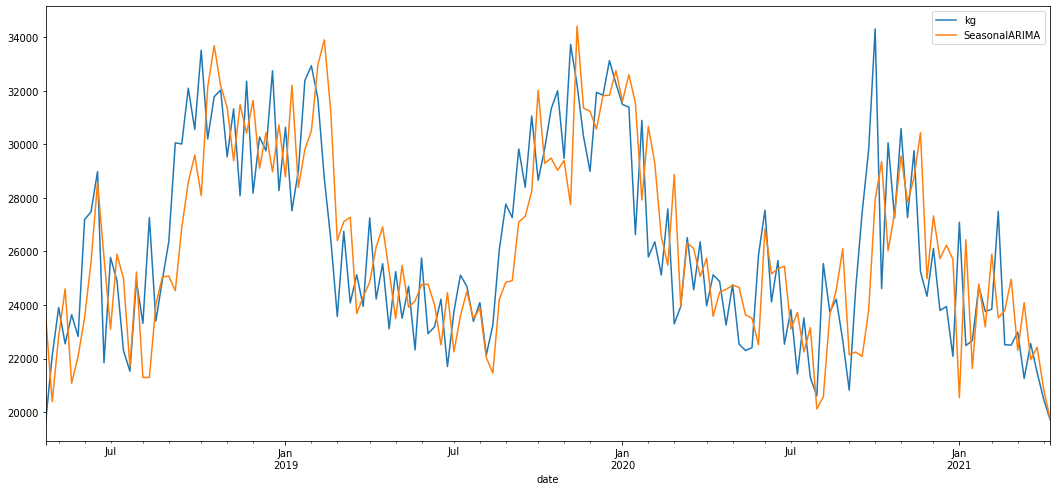

In [98]:
# 2017년 12개월 데이터로 예측
SARIMA_predict_week_1 = SARIMA_results_week.predict(start=cut,end=len(week))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
week_test_final['SeasonalARIMA'] = SARIMA_predict_week_1

# RMSE를 살펴 봄
RMSE_week_Seasonal_ARIMA  = np.sqrt(np.mean((week_test_final['SeasonalARIMA'] - week_test_final['kg']) ** 2)) 
print(RMSE_week_Seasonal_ARIMA)

# test 데이터와 예측 결과치를 비교
week_test_final[1:].plot()

In [38]:
## 앞으로의 예측치

fore = SARIMA_results_week.forecast(steps=10)
print(fore)

2021-04-18    23365.091481
2021-04-25    21427.546794
2021-05-02    22317.310459
2021-05-09    21593.899589
2021-05-16    19017.409885
2021-05-23    21097.774530
2021-05-30    21844.256294
2021-06-06    22336.315283
2021-06-13    24163.612199
2021-06-20    21042.704067
Freq: W-SUN, dtype: float64


## 주별 예측 - 결측치 다시채우기

In [65]:
from pylab import rcParams
import statsmodels.api as sm
import statsmodels.tsa.seasonal as seasonal_decompose
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

df = pd.read_csv('./전복_전처리2.csv')

df.rename(columns = {'1kg 평균가격' : 'kg','월':'month','년도':'year','생산량':'pr','수온 (℃)':'tem (℃)','일시':'date'}, inplace = True)

df['date'] =  pd.to_datetime(df['date'])
df_2 = df.set_index('date')

week = pd.DataFrame(df_2.kg.resample('W').mean(), columns=['kg'])

### 결측치 제거

- 주별로 했을때 (도메인 지식)

In [66]:
week

,kg
date,
2006-04-02,31600.000000
2006-04-09,32966.666667
2006-04-16,34033.333333
2006-04-23,31561.904762
2006-04-30,34706.434837
...,...
2021-03-14,21261.467532
2021-03-21,22559.491588
2021-03-28,21481.954269


In [67]:
week.isnull().sum()

kg    14
dtype: int64

In [68]:
t = week[week['kg'].isna()].index
t

DatetimeIndex(['2008-01-20', '2008-02-03', '2008-02-24', '2008-03-02',
               '2009-06-07', '2009-06-14', '2011-06-19', '2011-06-26',
               '2011-07-03', '2011-07-24', '2011-07-31', '2011-08-07',
               '2011-08-14', '2012-09-09'],
              dtype='datetime64[ns]', name='date', freq=None)

In [69]:
# 앞에 데이터로 넣어줌
week = week.fillna(method='ffill', limit=1)
week[week['kg'].isna()]

,kg
date,
2008-03-02,NaN
2009-06-14,NaN
2011-06-26,NaN
2011-07-03,NaN
2011-07-31,NaN
2011-08-07,NaN
2011-08-14,NaN


In [70]:
week = week.fillna(method='bfill', limit=1)
week[week['kg'].isna()]

,kg
date,
2011-06-26,NaN
2011-07-31,NaN
2011-08-07,NaN


In [71]:
week = week.fillna(method='ffill', limit=1)
week = week.fillna(method='bfill', limit=1)
week[week['kg'].isna()]

,kg
date,


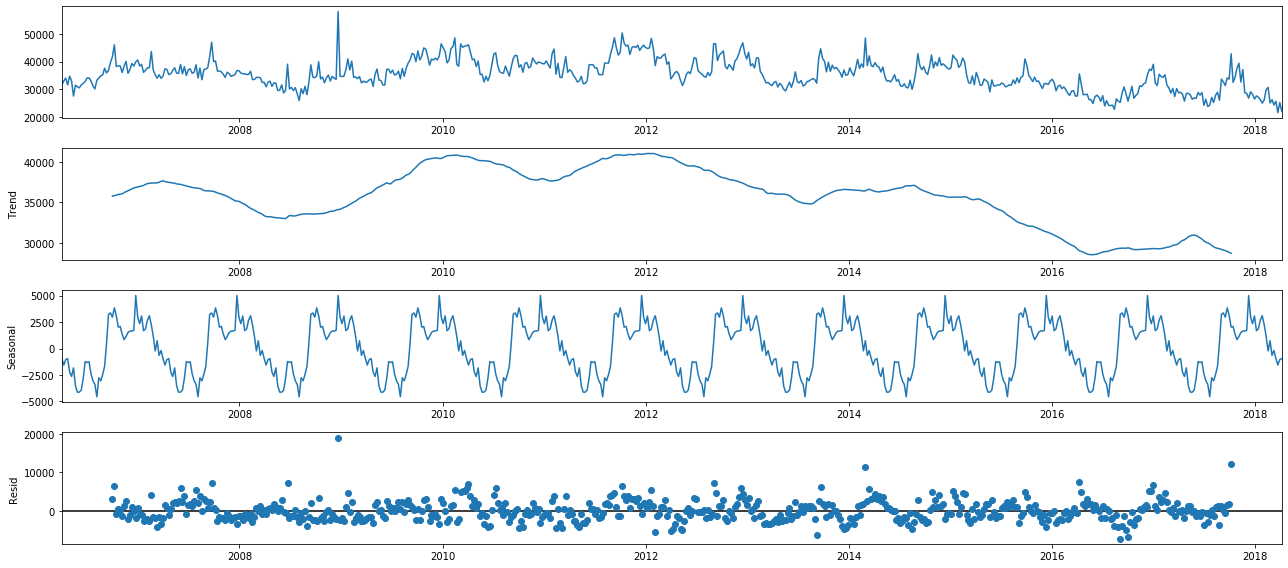

In [72]:
ratio = 0.8
cut = np.int(len(week)*ratio)
week_train = week[:cut]
week_test = week[cut:]
week_test_final=week_test.copy()

# 데이터를 시즌별로 분해해서 살펴 봄
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(week_train, model='additive')
fig = decomposition.plot()
plt.show()

In [54]:
# pip install pmdarima

In [55]:
#방법 1. p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2) # pdq에 0,1 넣어줌

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(week_train, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
#방법 2. auto_arima 함수로 자동 추출
from pmdarima import auto_arima
stepwise_model = auto_arima(week_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14930.061891209403
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:14225.169227930284
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:12290.359902851858
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11992.270846872421
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:12306.085584062843
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:12270.445794954754
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:12040.593380953931
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11989.310970021546
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:14461.474997462003
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14080.625135959082
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:12072.716206749676
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:11754.359907847118
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:12098.53214220277
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:14020.106774474274
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11825.704589065885
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:11756.16730613362
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:11818.42605934549
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11597.68790747

In [ ]:
# AIC가 가장 작은 조합을 선택 Best model:  Best model:  ARIMA(3,1,0)(2,1,0)[12]

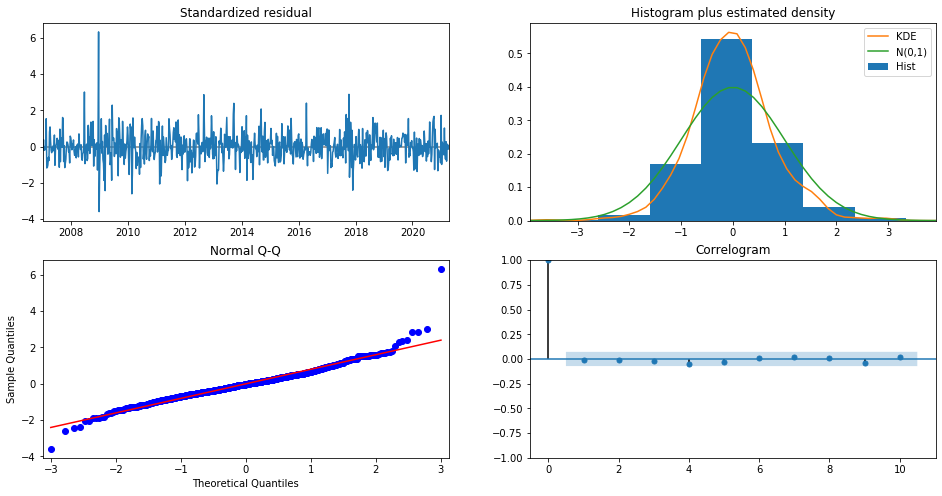

In [73]:
SARIMAweek = sm.tsa.statespace.SARIMAX(week, order=(3, 1, 0), seasonal_order=(2, 1, 0, 12) ,enforce_stationarity=False,enforce_invertibility=False)

SARIMA_results_week = SARIMAweek.fit()

SARIMA_results_week.plot_diagnostics(figsize=(16, 8))
plt.show()

2533.2323930281955


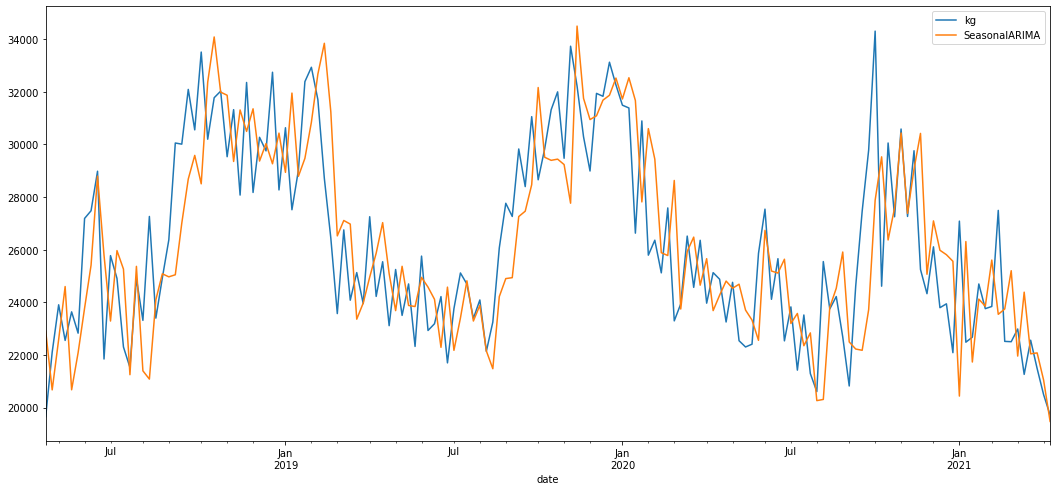

In [93]:
# 2017년 12개월 데이터로 예측
SARIMA_predict_week_1 = SARIMA_results_week.predict(start=cut,end=len(week))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
week_test_final['SeasonalARIMA'] = SARIMA_predict_week_1

# RMSE를 살펴 봄
RMSE_week_Seasonal_ARIMA  = np.sqrt(np.mean((week_test_final['SeasonalARIMA'] - week_test_final['kg']) ** 2)) 
print(RMSE_week_Seasonal_ARIMA)

# test 데이터와 예측 결과치를 비교
week_test_final[1:].plot()

In [94]:
## 앞으로의 예측치

fore = SARIMA_results_week.forecast(steps=10)
print(fore)

2021-04-18    23387.130005
2021-04-25    21388.132046
2021-05-02    22256.210831
2021-05-09    21567.286944
2021-05-16    18985.080383
2021-05-23    21037.075552
2021-05-30    21757.550460
2021-06-06    22222.202624
2021-06-13    24019.977976
2021-06-20    20976.246588
Freq: W-SUN, dtype: float64


In [95]:
RMSE_week_Seasonal_ARIMA  = np.sqrt(np.mean((week_test_final['SeasonalARIMA'] - week_test_final['kg']) ** 2)) 
print('RMSE: %f' % RMSE_week_Seasonal_ARIMA)


RMSE_week_Seasonal_ARIMA  = np.sqrt(np.mean((np.log1p(week_test_final['SeasonalARIMA']) - np.log1p(week_test_final['kg'])) ** 2)) 
print('로그 변환 RMSE: %f' % RMSE_week_Seasonal_ARIMA)


RMSE: 2533.232393
로그 변환 RMSE: 0.096094
